Se carga el dataset que se utilizara

In [1]:
from pandas import DataFrame
import pandas as pd

dataset =  DataFrame(pd.read_csv('windserie.csv', header=None))
print(dataset.head)

<bound method NDFrame.head of          0
0      6.0
1      7.1
2     10.0
3      6.9
4      8.4
5      8.9
6      6.7
7      7.6
8      3.9
9      4.9
10     3.6
11     3.4
12     2.7
13     2.2
14     3.0
15     2.6
16     3.0
17     2.7
18     4.0
19     3.8
20     3.9
21     5.8
22     7.2
23     6.8
24     5.9
25     6.4
26     6.7
27     7.6
28     6.9
29     4.8
...    ...
4212   3.4
4213   4.2
4214   4.8
4215   2.3
4216   3.0
4217   2.7
4218   3.0
4219   2.6
4220   2.5
4221   3.3
4222   7.7
4223   9.7
4224  12.7
4225  13.2
4226  12.7
4227  15.8
4228  13.6
4229   9.1
4230   5.3
4231   2.8
4232   5.0
4233   4.5
4234   3.3
4235   3.4
4236   3.4
4237   2.8
4238   2.5
4239   2.4
4240   2.9
4241   2.8

[4242 rows x 1 columns]>


Se aplica media movil en los datos.

In [2]:
from matplotlib import pyplot

dataset_soft = dataset.rolling(window=2, min_periods=1).mean()

pyplot.figure(num=None, figsize=(18, 6), dpi=320, facecolor='w', edgecolor='k')
pyplot.style.use("ggplot")
pyplot.plot(dataset[1:150], label='Input')
pyplot.plot(dataset_soft[1:150], label='Soft')
pyplot.title('Media móvil Aplicada')
pyplot.legend()
pyplot.show()

<Figure size 5760x1920 with 1 Axes>

Definimos el tamaño de imagen que se utilizara (en pixeles). Y se preparan datos para su conversión

In [3]:
import Tools as tls
import numpy as np

IMAGE_SIZE=32
X_train, y_train, X_test, y_test = tls.SerieToImage(dataset_soft, IMAGE_SIZE)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],X_train.shape[2], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],X_test.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2810, 32, 32, 1) (1368, 32, 32, 1) (2810, 1) (1368, 1)


Se envian matrices de datos de series de tiempo para generar las imagenes en formato jepg. Se guardan en el directiorio definido.

In [4]:
from matplotlib import pyplot
from matplotlib import image

tls.imageDataToJPG(X_train, y_train, 'images/train')
tls.imageDataToJPG(X_test, y_test, 'images/test')


Se muestra ejemplo imagen

Ejemplo serie de tiempo como imagen


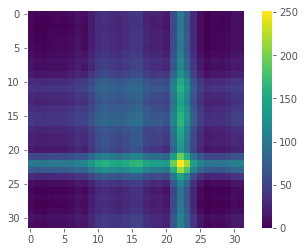

In [5]:
print('Ejemplo serie de tiempo como imagen')
img = image.imread('images/train/13.jpeg')
pyplot.figure()
pyplot.imshow(img)
pyplot.colorbar()
pyplot.grid(False)


Se construye modelo y se compila

In [9]:
from keras.layers import Convolution2D, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential

filt = 32
kernel = 3
dropout = 0.05
in_shape = (IMAGE_SIZE,IMAGE_SIZE,1)

model = Sequential((
            Convolution2D(filters=filt,kernel_size=kernel, activation='relu',input_shape=in_shape),
            MaxPooling2D(pool_size=(3, 3)),
            Convolution2D(filters=filt,kernel_size=kernel, activation='relu'),
            MaxPooling2D(pool_size=(3, 3)),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.05),
            Dense(1,activation='linear'),
            ))     
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

Se entrena modelo y se guarda historia.

In [10]:
epochs = 30
history = model.fit(X_train, y_train, epochs=epochs, batch_size=24, validation_data=(X_test, y_test), verbose = 1)

Train on 2810 samples, validate on 1368 samples
Epoch 1/30


UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_3/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training_1/Adam/gradients/conv2d_3/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/Adam/gradients/conv2d_3/convolution_grad/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer, conv2d_3/kernel/read)]]
	 [[{{node loss_1/mul/_225}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_636_loss_1/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Se grafican MSE y MAE

In [ ]:
pyplot.style.use("ggplot")
pyplot.figure()
N = epochs
pyplot.figure(num=None, figsize=(8, 6), dpi=320, facecolor='w', edgecolor='k')
pyplot.plot(np.arange(0, N), history.history["mean_squared_error"], label="mse")
pyplot.plot(np.arange(0, N), history.history["val_mean_squared_error"], label="val_mse")
pyplot.title("Training MSE")
pyplot.xlabel("Epoch #")
pyplot.ylabel("MSE")
pyplot.legend(loc="upper right")
pyplot.show()

Se realizan predicciones con datos de prueba y se grafican

In [ ]:
#Se realizan predicciones con datos de prueba
predictions = model.predict(X_test, 24, verbose=2)
    
#Se grafican predicciones
pyplot.figure(num=None, figsize=(18, 6), dpi=320, facecolor='w', edgecolor='k')
pyplot.plot(y_test[1:100,], label='Real')
pyplot.plot(predictions[1:100,], label='Predicción')
pyplot.title('Valor predicción contra real')
pyplot.xlabel('Epochs')
pyplot.ylabel('Value')
pyplot.legend()
pyplot.show()